In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from huggingface_hub import whoami
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel

/Users/nicholasyousefi/Documents/Coding/School/Harvard/Fall_2025/ac215/project/ac215_Group_127_2473879/src/ml_workflow/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    user_info = whoami()
    print(f"Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Not logged in: {e}")

Logged in as: nsyousefi


In [3]:
# Setup
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Models to test
MODELS = {
    'pubmedbert': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
    'biosyn': 'dmis-lab/biosyn-sapbert-bc5cdr-disease',
    'sapbert': 'cambridgeltl/SapBERT-from-PubMedBERT-fulltext',
    'qwen': 'Qwen/Qwen3-Embedding-8B'
}

Using device: mps


In [4]:
def encode_texts(
    model_name: str,
    texts: list,
    batch_size: int = 32,
    max_length: int = 512,
    normalize: bool = True,
    pooling: str = "mean"  # "mean" or "cls"
) -> np.ndarray:
    """Generate embeddings using transformers with mean or cls pooling and L2 normalization"""

    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    mdl = AutoModel.from_pretrained(model_name).to(DEVICE).eval()
    
    # ===== VALIDATE POOLING OPTION =====
    if pooling not in ("mean", "cls"):
        raise ValueError(f"Invalid pooling method: '{pooling}'. Use 'mean' or 'cls'.")

    # For 'cls' pooling, tokenizer must provide a [CLS] token
    if pooling == "cls":
        if not hasattr(tok, "cls_token") or (tok.cls_token is None):
            raise ValueError(
                f"Pooling method 'cls' is not supported for model '{model_name}': tokenizer does not define a [CLS] token."
            )
    
    embs = []
    for i in range(0, len(texts), batch_size):
        chunk = texts[i:i+batch_size]
        enc = tok(chunk, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(DEVICE)
        
        with torch.no_grad():
            out = mdl(**enc)
            last = out.last_hidden_state  # [batch, tokens, hid]
            mask = enc["attention_mask"].unsqueeze(-1)  # [batch, tokens, 1]

            if pooling == "mean":
                masked = last * mask
                vec = masked.sum(dim=1) / torch.clamp(mask.sum(dim=1), min=1e-6)
            elif pooling == "cls":
                vec = last[:, 0, :]  # [CLS] token is the first token
            else:
                raise ValueError(f"Invalid pooling method: '{pooling}'. Use 'mean' or 'cls'.")
            
            embs.append(vec.cpu().numpy())
    
    embs = np.vstack(embs)
    
    # L2 normalization
    if normalize:
        norms = np.linalg.norm(embs, axis=1, keepdims=True)
        embs = embs / (norms + 1e-12)
    
    return embs

In [5]:
# Load data
metadata = pd.read_csv('../../../data/metadata_all_harmonized.csv')
descriptions_df = metadata[metadata['text_desc'].notna() & (metadata['text_desc'] != '')].copy()
print(f"Samples with text descriptions: {len(descriptions_df)}")

# Filter for diseases with at least 20 samples
label_counts = descriptions_df['label'].value_counts()
common_diseases = label_counts[label_counts >= 20].index
filtered_df = descriptions_df[descriptions_df['label'].isin(common_diseases)].copy()

texts = filtered_df['text_desc'].tolist()
labels = filtered_df['label'].tolist()
print(f"Dataset (more than 20 samples for label): {len(filtered_df)} samples, {len(common_diseases)} diseases")


Samples with text descriptions: 1189
Dataset (more than 20 samples for label): 733 samples, 14 diseases


In [6]:
def evaluate_kmeans(embeddings, labels, model_name):
    """Evaluate KMeans clustering with multiple restarts"""
    n_clusters = len(set(labels))
    # KMeans with k-means++ initialization and multiple restarts
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    # Calculate metrics
    ari = adjusted_rand_score(labels, cluster_labels)
    sil_score = silhouette_score(embeddings, cluster_labels, metric='cosine')
    
    return {
        'ARI': ari,
        'Silhouette': sil_score,
        'cluster_labels': cluster_labels
    }

def plot_embeddings(embeddings, labels, title, method='PCA'):
    """Plot 2D visualization with colored labels and legend"""
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    
    embeddings_2d = reducer.fit_transform(embeddings)
    unique_labels = sorted(set(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    plt.figure(figsize=(12, 8))
    
    for label in unique_labels:
        mask = np.array(labels) == label
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], c=[label_to_color[label]], label=label, alpha=0.7, s=50)
    
    plt.title(f'{title} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [7]:
# Generate embeddings and evaluate for all models
results = {}

for model_name, model_path in MODELS.items():
    print(f"\n{'='*25}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*25}")
    
    try:
        # Generate embeddings
        print(f"Generating embeddings...")
        embeddings = encode_texts(model_path, texts, batch_size=32, max_length=512)
        print(f"Embeddings shape: {embeddings.shape}")
        
        # Evaluate KMeans
        print(f"Running KMeans clustering...")
        metrics = evaluate_kmeans(embeddings, labels, model_name)
        results[model_name] = {'embeddings': embeddings, 'metrics': metrics}
        
        print(f"\nRESULTS:")
        print(f"  ARI: {metrics['ARI']:.4f}")
        print(f"  Silhouette: {metrics['Silhouette']:.4f}")
        
    except Exception as e:
        print(f"ERROR: {e}")
        continue



EVALUATING PUBMEDBERT
Generating embeddings...
ERROR: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

EVALUATING BIOSYN
Generating embeddings...
ERROR: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

EVALUATING SAPBERT
Generating embeddings...


Cancellation requested; stopping current tasks.
Exception in thread Thread-auto_conversion:
Traceback (most recent call last):
  File "/Users/nicholasyousefi/miniconda3/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/Users/nicholasyousefi/Documents/Coding/School/Harvard/Fall_2025/ac215/project/ac215_Group_127_2473879/src/ml_workflow/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 788, in run_closure
    _threading_Thread_run(self)
  File "/Users/nicholasyousefi/miniconda3/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicholasyousefi/Documents/Coding/School/Harvard/Fall_2025/ac215/project/ac215_Group_127_2473879/src/ml_workflow/.venv/lib/python3.12/site-packages/transformers/safetensors_conversion.py", line 101, in auto_conversion
    resolved_archive_file = cached_file(pretrained_model_name_or_path, filename, **cached_file_kwargs)
                            ^^^^^^^^^^^^^

KeyboardInterrupt: 


Best model: sapbert
Best ARI: 0.2336

Creating PCA visualization for sapbert...


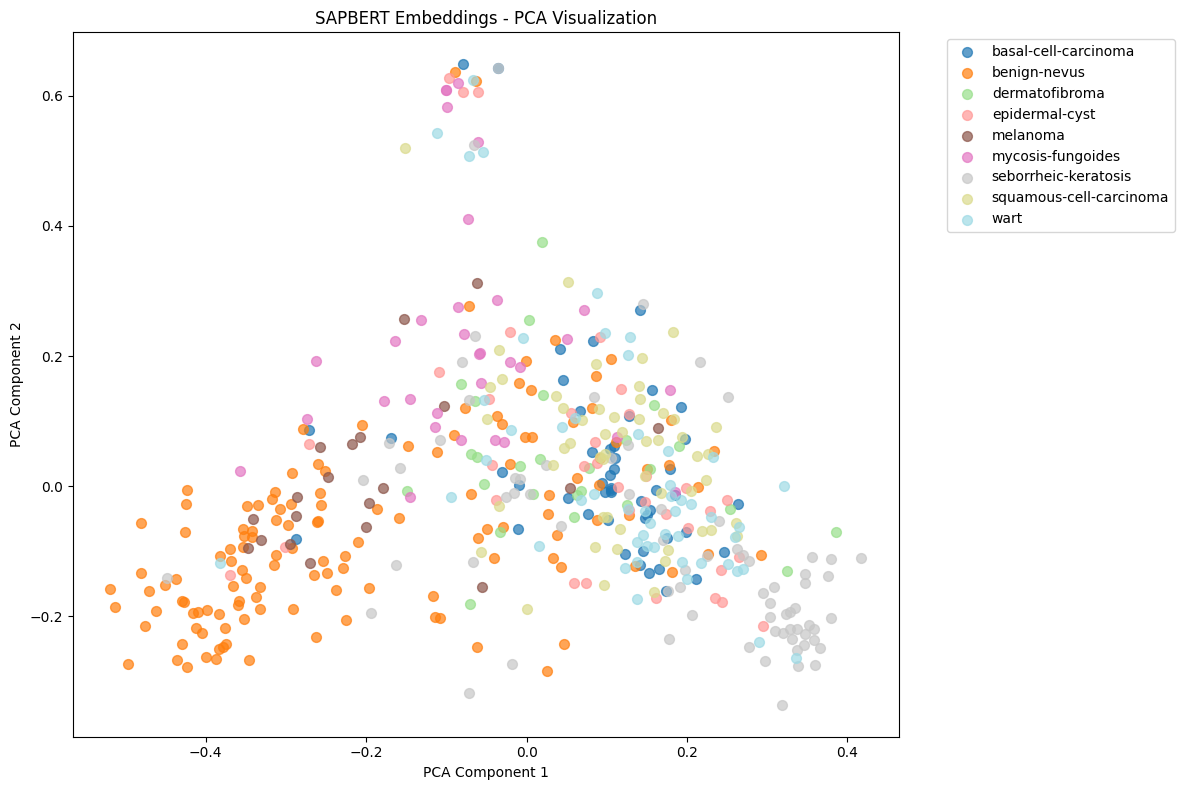

Creating t-SNE visualization for sapbert...


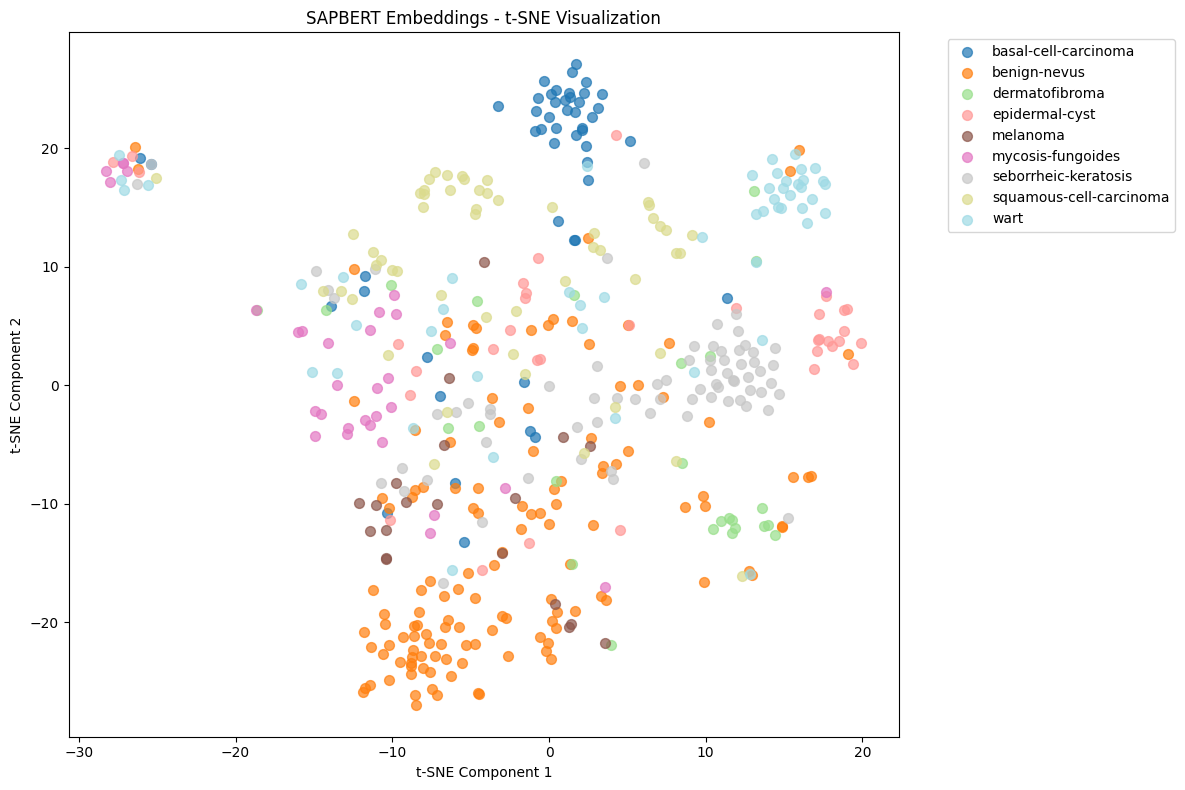

In [10]:
# Find best model and create visualizations
if results:
    best_model = max(results.keys(), key=lambda x: results[x]['metrics']['ARI'])
    print(f"\nBest model: {best_model}")
    print(f"Best ARI: {results[best_model]['metrics']['ARI']:.4f}")
    # Create visualizations for best model
    best_embeddings = results[best_model]['embeddings']
    
    print(f"\nCreating PCA visualization for {best_model}...")
    plot_embeddings(best_embeddings, labels, f'{best_model.upper()} Embeddings', method='PCA')
    
    print(f"Creating t-SNE visualization for {best_model}...")
    plot_embeddings(best_embeddings, labels, f'{best_model.upper()} Embeddings', method='t-SNE')
else:
    print("No models successfully processed")


In [9]:
# Summary table
if results:
    summary_data = []
    for model_name, data in results.items():
        metrics = data['metrics']
        summary_data.append({
            'Model': model_name,
            'ARI': metrics['ARI'],
            'Silhouette': metrics['Silhouette']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('ARI', ascending=False)
    
    print("\n=== MODEL COMPARISON ===")
    print(summary_df.round(4))
    
    print(f"\nBest performing model: {summary_df.iloc[0]['Model']}")
    print(f"Best ARI score: {summary_df.iloc[0]['ARI']:.4f}")
    print(f"Best Silhouette score: {summary_df.iloc[0]['Silhouette']:.4f}")



=== MODEL COMPARISON ===
        Model     ARI  Silhouette
2     sapbert  0.2336      0.2010
1      biosyn  0.2191      0.2271
3        qwen  0.1966      0.2427
0  pubmedbert  0.1520      0.1672

Best performing model: sapbert
Best ARI score: 0.2336
Best Silhouette score: 0.2010
